In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
ocr_dir = "/content/drive/My Drive/OCR_output"

In [ ]:
!pip install faiss-cpu

# Load and normalize OCR text

In [ ]:
import os

agreements = {}

for state_dir in os.listdir(ocr_dir):
    state_path = os.path.join(ocr_dir, state_dir)
    if os.path.isdir(state_path):
        for fname in os.listdir(state_path):
            if fname.endswith(".txt"):
                fpath = os.path.join(state_path, fname)
                with open(fpath, "r", encoding="utf-8", errors="ignore") as f:
                    text = f.read()
                    agreements[f"{state_dir}/{fname}"] = text
print(f"Loaded {len(agreements)} agreements.")

Loaded 298 agreements.


**Sample a small subset of agreements**

In [ ]:
# Zamiast losowania, przypisujemy wszystkie dane
agreements_sample = agreements
print(f"Using ALL {len(agreements_sample)} agreements.")

Using ALL 298 agreements.


In [ ]:
#to have correct order in list
sample_keys = list(agreements_sample.keys())
sample_texts = [agreements_sample[k] for k in sample_keys]

# Deduplication task

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import faiss
import re

# 1) Load Legal-SBERT model
model = SentenceTransformer("bhavyagiri/InLegal-Sbert")

# 2) Compute embeddings
embeddings = model.encode(sample_texts, convert_to_numpy=True, normalize_embeddings=True)

# 3) Build FAISS index
d = embeddings.shape[1]
index = faiss.IndexFlatIP(d)
index.add(embeddings)

# -----------------------------
# 4) Deduplication (Modified to count unique pairs)
# -----------------------------
SIM_THRESHOLD = 0.85
D, I = index.search(embeddings, k=2)

duplicate_pairs = set()
for idx, (scores, nbrs) in enumerate(zip(D, I)):
    # nbrs[0] is always the document itself. nbrs[1] is the closest match.
    if scores[1] >= SIM_THRESHOLD:
        # Sort the pair to ensure (A, B) and (B, A) are treated as the same duplicate
        pair = tuple(sorted((sample_keys[idx], sample_keys[nbrs[1]])))
        duplicate_pairs.add(pair)

print(f"--- DEDUPLICATION RESULTS ---")
print(f"Total unique duplicate pairs found: {len(duplicate_pairs)}")
if len(duplicate_pairs) > 0:
    print("Example Duplicates:")
    for p1, p2 in list(duplicate_pairs)[:5]:
        print(f" - {p1} <-> {p2}")

# -----------------------------
# 5) Sister Cities % (Point 4)
# -----------------------------
# Using Regex for better accuracy as discussed
sci_pattern = r"sister\s+cities\s+international|sci\b|sister\s+city"
sci_count = sum(1 for text in sample_texts if re.search(sci_pattern, text.lower()))
percent_sci = (sci_count / len(sample_texts)) * 100

print(f"\n--- (4) SISTER CITIES INTERNATIONAL ---")
print(f"Agreements mentioning SCI: {sci_count}")
print(f"Percentage: {percent_sci:.2f}%")

# -----------------------------
# 6) Partner Complexity (Point 10)
# -----------------------------
partner_word_counts = {}
for key, text in zip(sample_keys, sample_texts):
    first_line = text.split("\n")[0].strip()[:50] # Limit length for printing
    words = len(text.split())
    partner_word_counts[first_line] = partner_word_counts.get(first_line, []) + [words]

avg_words_per_partner = {p: sum(lst)/len(lst) for p, lst in partner_word_counts.items()}
sorted_avg_words = sorted(avg_words_per_partner.items(), key=lambda x: x[1], reverse=True)

print("\n--- (10) TOP PARTNERS BY DETAIL (AVG WORDS) ---")
for p, w in sorted_avg_words[:5]:
    print(f"{w:.0f} words: {p}...")

# -----------------------------
# 7) Coordination & Legal Refs (Points 12 & 13)
# -----------------------------
coord_keywords = ["coordination with", "in collaboration with", "jointly with"]
legal_refs_keywords = ["pursuant to", "in accordance with", "reference to", "governed by"]

coord_count = sum(1 for text in sample_texts if any(kw in text.lower() for kw in coord_keywords))
legal_count = sum(1 for text in sample_texts if any(kw in text.lower() for kw in legal_refs_keywords))

print("\n--- (12 & 13) STRUCTURAL FLAGS ---")
print(f"Agreements mentioning Coordination: {coord_count} ({ (coord_count/len(sample_texts))*100 :.1f}%)")
print(f"Agreements with Legal References: {legal_count} ({ (legal_count/len(sample_texts))*100 :.1f}%)")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


--- DEDUPLICATION RESULTS ---
Total unique duplicate pairs found: 243
Example Duplicates:
 - Hawaii/Hawaii_35.txt <-> Ohio/Ohio_7.txt
 - Arizona/Arizona_12.txt <-> Arizona/Arizona_12.txt
 - Alabama/Alabama_6.txt <-> Texas/Texas_33.txt
 - California/1282023 (1).txt <-> California/1282023 (1).txt
 - Texas/Texas_9.txt <-> Virginia/Virgina_1.txt

--- (4) SISTER CITIES INTERNATIONAL ---
Agreements mentioning SCI: 5
Percentage: 1.68%

--- (10) TOP PARTNERS BY DETAIL (AVG WORDS) ---
7367 words: APPENDIX I to the Memorandum of Understanding and ...
5837 words: P...
4405 words: RP-2020-77990...
4306 words: Contract No.: 50-OXXF9001...
4132 words: PACIFIC COAST CLIMATE...

--- (12 & 13) STRUCTURAL FLAGS ---
Agreements mentioning Coordination: 27 (9.1%)
Agreements with Legal References: 133 (44.6%)


In [ ]:
import re

sci_patterns = [
    r"sister\s+cities\s+international",
    r"sister\s+cities\s+int\.?",
    r"sister\s+city\s+international",
    r"sister\s+cities\b",
    r"sister\s+city\b",
    r"\bsci\b"
]


In [ ]:
def mentions_sci(text):
    text = text.lower()
    return any(re.search(pat, text) for pat in sci_patterns)


In [ ]:
sci_count = sum(1 for text in sample_texts if mentions_sci(text))
percent_sci = sci_count / len(sample_texts) * 100

print(f"Sister Cities (incl. variants) mentioned in {percent_sci:.2f}% of sampled agreements")


Sister Cities (incl. variants) mentioned in 1.68% of sampled agreements


We can see that for shortcuts some phraeses for Sister Cities International appers

In [ ]:
# Ustawiamy sample_keys na wszystkie dostępne klucze
sample_keys = list(agreements.keys())
sample_texts = [agreements[k] for k in sample_keys]

print(f"Total size for processing: {len(sample_keys)}")

Total size for processing: 298


In [ ]:
sci_count = sum(1 for text in sample_texts if mentions_sci(text))
percent_sci = sci_count / len(sample_texts) * 100

print(f"Sister Cities (incl. variants) mentioned in {percent_sci:.2f}% of sampled agreements")

Sister Cities (incl. variants) mentioned in 1.68% of sampled agreements


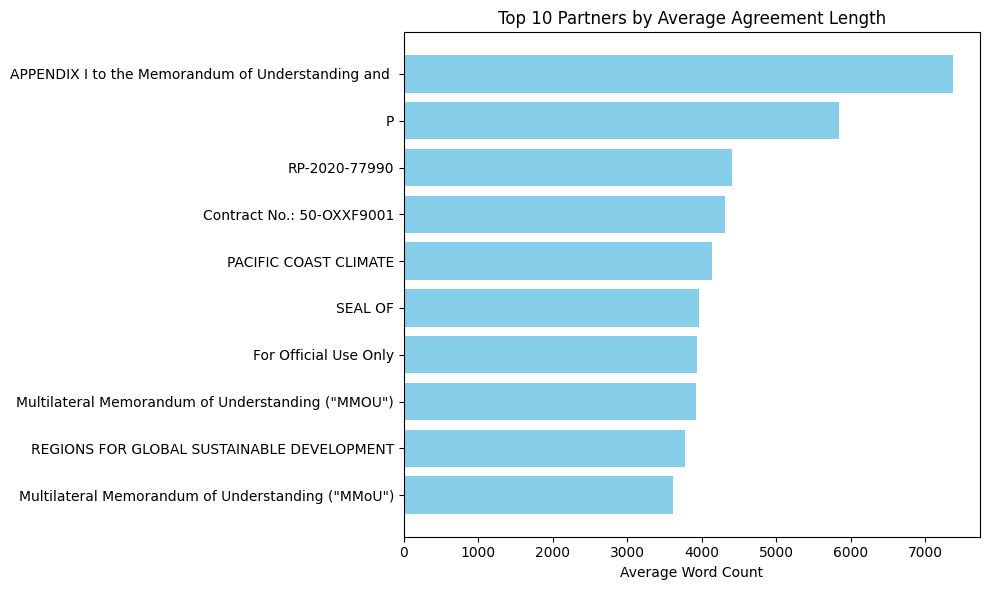

In [ ]:
import matplotlib.pyplot as plt

# Data preparation (using the top 10 partners for better visibility)
top_partners = sorted_avg_words[:10]
names = [p[0] for p in top_partners]
counts = [p[1] for p in top_partners]

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.barh(names, counts, color='skyblue')
plt.xlabel('Average Word Count')
plt.title('Top 10 Partners by Average Agreement Length')
plt.gca().invert_yaxis()  # Put the longest agreements at the top
plt.tight_layout()

# Save and show
plt.savefig('top_partners_length.png')
plt.show()

Now we see that our code works.

As we have representad dataset now, we can start again whole counting for our poc.

**Recounted -final results for stratified poc dataset:**

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import faiss

# 1) Load Legal-SBERT model
model = SentenceTransformer("bhavyagiri/InLegal-Sbert")


# 2) Compute embeddings
embeddings = model.encode(sample_texts, convert_to_numpy=True, normalize_embeddings=True)
sim_matrix = cosine_similarity(embeddings)

# 3) Build FAISS index
d = embeddings.shape[1]
index = faiss.IndexFlatIP(d)
index.add(embeddings)

# 4) Search for duplicates
SIM_THRESHOLD = 0.85
D, I = index.search(embeddings, k=2)

duplicates = []
for idx, (scores, nbrs) in enumerate(zip(D, I)):
    if nbrs[1] != idx and scores[1] >= SIM_THRESHOLD:
        duplicates.append((sample_keys[idx], sample_keys[nbrs[1]], scores[1]))

print("Duplicates found:", duplicates)

# -----------------------------
# 5) Sister Cities % calculation

sci_count = sum(1 for text in sample_texts if "Sister Cities International" in text)
percent_sci = sci_count / len(sample_texts) * 100
print(f"\nSister Cities International mentioned in {percent_sci:.2f}% of sampled agreements")

# -----------------------------
# 6) Partner-level detail (avg word count)

partner_word_counts = {}
for key, text in zip(sample_keys, sample_texts):
    first_line = text.split("\n")[0].strip()  # heuristic for partner name
    words = len(text.split())
    partner_word_counts[first_line] = partner_word_counts.get(first_line, []) + [words]

avg_words_per_partner = {p: sum(lst)/len(lst) for p, lst in partner_word_counts.items()}
sorted_avg_words = sorted(avg_words_per_partner.items(), key=lambda x: x[1], reverse=True)

print("\nTop partners by average agreement length (words):")
for p, w in sorted_avg_words[:5]:
    print(f"{p}: {w:.0f} words")

# -----------------------------
# 7) Coordination & Legal References flags

coord_keywords = ["coordination with", "in collaboration with", "jointly with"]
legal_refs_keywords = ["see", "refer to", "pursuant to", "in accordance with", "as per"]

coordination_flags = {k: any(kw in text.lower() for kw in coord_keywords)
                      for k, text in zip(sample_keys, sample_texts)}
legal_refs_flags = {k: any(kw in text.lower() for kw in legal_refs_keywords)
                    for k, text in zip(sample_keys, sample_texts)}

print("\nSample coordination flags:")
for k, flag in list(coordination_flags.items())[:5]:
    print(f"{k}: {flag}")

print("\nSample legal references flags:")
for k, flag in list(legal_refs_flags.items())[:5]:
    print(f"{k}: {flag}")

Duplicates found: [('Alaska/Alaska_1.txt', 'Alaska/Alaska_10.txt', np.float32(0.9745388)), ('Alaska/Alaska_10.txt', 'Alaska/Alaska_1.txt', np.float32(0.9745388)), ('Alaska/Alaska_11.txt', 'Alaska/Alaska_8.txt', np.float32(0.9524404)), ('Alaska/Alaska_12.txt', 'Texas/Texas_40.txt', np.float32(0.97275174)), ('Alaska/Alaska_2.txt', 'Arkansas/Arkansas_6.txt', np.float32(0.9557996)), ('Alaska/Alaska_3.txt', 'Alaska/Alaska_5.txt', np.float32(0.98330456)), ('Alaska/Alaska_4.txt', 'North Carolina/NorthCarolina_7.txt', np.float32(0.9604552)), ('Alaska/Alaska_5.txt', 'Alaska/Alaska_3.txt', np.float32(0.98330456)), ('Alaska/Alaska_6.txt', 'California/1June9.txt', np.float32(0.9575794)), ('Alaska/Alaska_7.txt', 'Michigan/Michigan_9.txt', np.float32(0.97000116)), ('Alaska/Alaska_9.txt', 'California/1September10.txt', np.float32(0.96087146)), ('Virginia/Virgina_1.txt', 'Texas/Texas_9.txt', np.float32(0.9706102)), ('Vermont/Vermont_11.txt', 'Alaska/Alaska_12.txt', np.float32(0.9684821)), ('Vermont/Ve

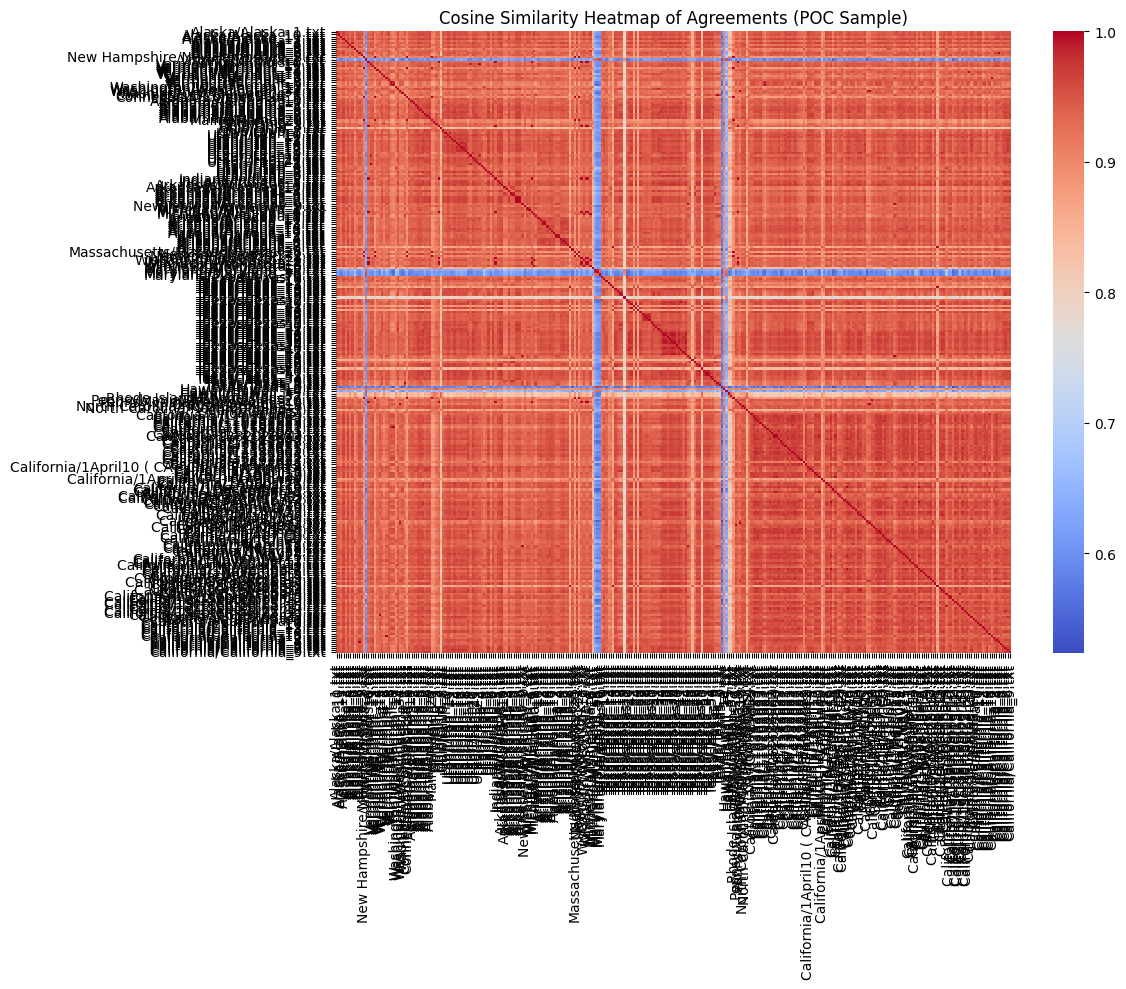

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Only for small POC (30 agreements) — otherwise too big
plt.figure(figsize=(12,10))
sns.heatmap(sim_matrix, xticklabels=sample_keys, yticklabels=sample_keys, cmap="coolwarm", annot=False)
plt.title("Cosine Similarity Heatmap of Agreements (POC Sample)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Comment:** *We see that some agreements repeate across states or repeat within one state - they are copies (example: Arkanas_9.txt & 1March15.txt, Arkanas_8.txt & Arkanas_7.txt)*

# Semantic Clustering (UMAP & HDBSCAN)

**Removing duplicates before clustering**

In [ ]:
# Removing of second element of each duplicate pair
duplicate_keys = set(d[1] for d in duplicates)
cluster_keys = [k for k in sample_keys if k not in duplicate_keys]
cluster_texts = [agreements[k] for k in cluster_keys]


**Embed texts with Legal-SBERT (reuse model)**

In [ ]:
embeddings_cluster = model.encode(
    cluster_texts,
    convert_to_numpy=True,
    normalize_embeddings=True
)


**Dimensionality reduction with UMAP**

In [ ]:
import umap

umap_model = umap.UMAP(
    n_neighbors=10,
    n_components=2,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

umap_embeddings = umap_model.fit_transform(embeddings_cluster)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


**Clustering with HDBSCAN**

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3,
    metric="euclidean",
    cluster_selection_method="eom"
)

cluster_labels = clusterer.fit_predict(umap_embeddings)


**Visualization of clusters**

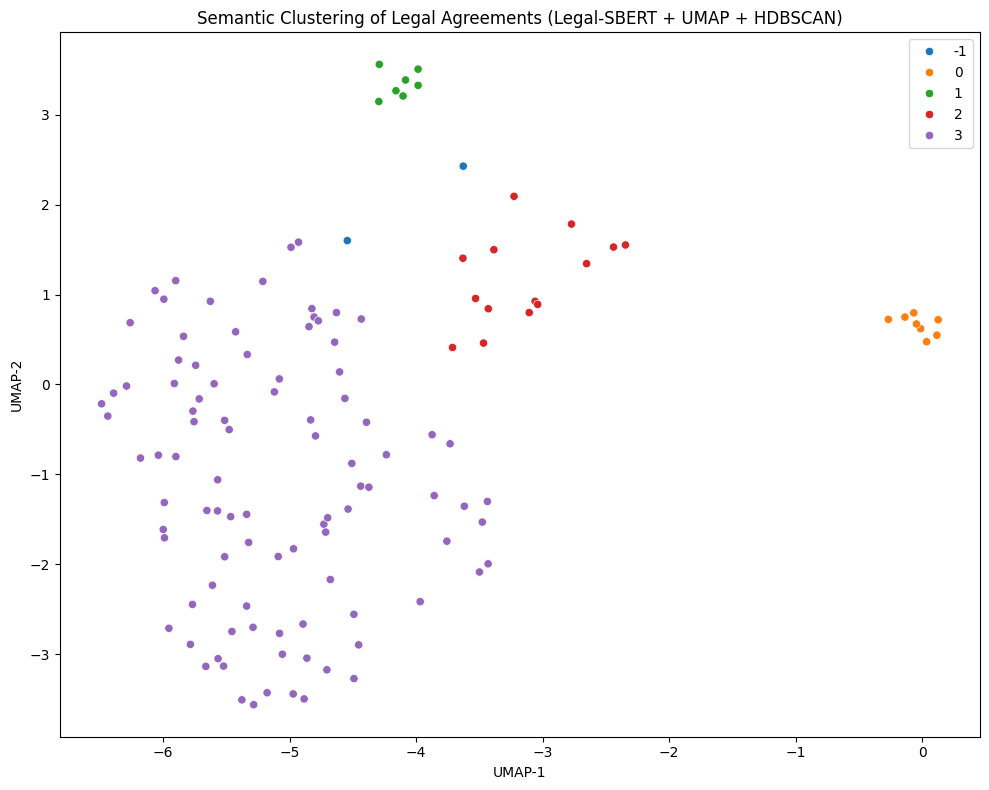

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=umap_embeddings[:, 0],
    y=umap_embeddings[:, 1],
    hue=cluster_labels,
    palette="tab10",
    legend="full"
)

plt.title("Semantic Clustering of Legal Agreements (Legal-SBERT + UMAP + HDBSCAN)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


Note:
* -1 → noise points

  * These are agreements that HDBSCAN thinks don’t belong to any dense cluster.
  * They are “outliers” or unique agreements.
  * Often agreements that are very short, very long, or have unusual clauses.

* 0, 1, 2, … → real clusters

  * HDBSCAN assigns a non-negative integer to each dense cluster it finds.
  * Each cluster contains agreements that are semantically similar according to Legal‑SBERT embeddings.

**Comment:** In our case many of agreements were labeled as -1 (so outliers) but its a normal for small subset of data for our POC (in final phase where we will consider full dataset we we expect a lower proportion of outliers). Additionally, for our subset we expected small amount of clusters as we have small amount of agreements inside it (30), in final phase we expect see more clusters.

**Inspection of clusters contents**

In [ ]:
import pandas as pd

cluster_df = pd.DataFrame({
    "Agreement": cluster_keys,
    "Cluster": cluster_labels,
    "Text": cluster_texts,
})

# Show agreements per cluster
for cid in sorted(cluster_df["Cluster"].unique()):
    print(f"\n🔹 Cluster {cid}")
    display(cluster_df[cluster_df["Cluster"] == cid][["Agreement"]])



🔹 Cluster -1


,Agreement
20,Ohio/Ohio_1.txt
59,Texas/Texas_13.txt



🔹 Cluster 0


,Agreement
6,Vermont/Vermont_11.txt
21,Ohio/Ohio_3.txt
32,Indiana/Indiana_2.txt
40,Michigan/Michigan_6.txt
50,New York/NewYork_4.txt
51,Wisconsin/Wisconsin_9.txt
52,Minnesota/Minesota_4.txt
80,Pennsylvania/Pennsylvania_8.txt



🔹 Cluster 1


,Agreement
4,Alaska/Alaska_7.txt
7,Vermont/Vermont_12.txt
13,Connecticut/Connecticut_6.txt
19,Maine/Maine_20.txt
48,Massachusetts/Massachusetts_26.txt
49,New York/NewYork_32.txt
79,Rhode Island/RhodeIsland_7.txt



🔹 Cluster 2


,Agreement
3,Alaska/Alaska_6.txt
54,Maryland/Maryland_10.txt
55,Maryland/Maryland_70.txt
60,Texas/Texas_19.txt
71,Texas/Texas_46.txt
72,Texas/Texas_5.txt
76,Hawaii/Hawaii_10.txt
77,Hawaii/Hawaii_14.txt
78,Hawaii/Hawaii_35.txt
88,California/18122021.txt



🔹 Cluster 3


,Agreement
0,Alaska/Alaska_11.txt
1,Alaska/Alaska_2.txt
2,Alaska/Alaska_4.txt
5,Alaska/Alaska_9.txt
8,Vermont/Vermont_13.txt
...,...
121,California/California_12.txt
122,California/California_16.txt
123,California/California_4.txt
124,California/California_5.txt


What is interesting for this subset (and we can expect it also for whol dataset) is that agreements that belongs to the same state are diffrent, not consider the same topic. We can assume that this is because we do not want to repeat the same subject in different agreements. A new agreement should concern something new, and when changes are made to a subject covered in an old agreement, that agreement should be updated rather than a new one created.

## Clusters interpretation

In [ ]:
import json

# Function to load JSON cleaned text for a single file
def load_ocr_json_with_pages(path: str) -> str:
    """Reconstruct cleaned text from OCR JSON with page markers"""
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    out_lines = []
    for p_idx, page in enumerate(data.get("pages", []), start=1):
        out_lines.append(f"[[PAGE={p_idx}]]")
        for block in page.get("blocks", []):
            for line in block.get("lines", []):
                words = [w.get("value","") for w in line.get("words", []) if w.get("value")]
                if words:
                    out_lines.append(" ".join(words))
        out_lines.append("")  # blank line between pages

    text = "\n".join(out_lines)
    # normalize whitespace
    text = re.sub(r"[ \t]+"," ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

# -----------------------------
# Build cluster_texts_json list for cluster_keys
# -----------------------------
cluster_texts_json = []

for k in cluster_keys:
    state, filename = k.split("/")  # e.g., "Texas", "Texas_14.txt"
    json_fname = filename.replace(".txt", ".json")
    json_path = os.path.join(ocr_dir, state, json_fname)

    if os.path.exists(json_path):
        cluster_texts_json.append(load_ocr_json_with_pages(json_path))
    else:
        # fallback to raw txt if JSON missing
        print(f"⚠️ JSON not found for {k}, using raw TXT instead")
        cluster_texts_json.append(cluster_texts[cluster_keys.index(k)])

In [ ]:
cluster_df["TextJSON"] = cluster_texts_json


In [ ]:
import re

# Lista wszystkich stanów USA (do detekcji w tekście)
US_STATES = [
    "Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut",
    "Delaware","Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa",
    "Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan",
    "Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","New Hampshire",
    "New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio",
    "Oklahoma","Oregon","Pennsylvania","Rhode Island","South Carolina","South Dakota",
    "Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia",
    "Wisconsin","Wyoming"
]

# -----------------------------
# Function to detect state(s) mentioned in cleaned JSON text
# -----------------------------
def extract_states(text):
    found = set()
    for state in US_STATES:
        # Case-insensitive search
        if re.search(rf"\b{state}\b", text, re.IGNORECASE):
            found.add(state)
    return list(found) if found else ["Unknown"]

# -----------------------------
# Apply to cluster_df
# -----------------------------
cluster_df["Partners"] = cluster_df["TextJSON"].apply(extract_states)

# If multiple states are detected, join them for display
cluster_df["PartnersDisplay"] = cluster_df["Partners"].apply(lambda x: ", ".join(x))

# Word count for detail
cluster_df["WordCount"] = cluster_df["Text"].apply(lambda x: len(x.split()))




🔹 Cluster -1 (N=2)
Top keywords: ['driver', 'license', 'france', 'department', 'french', 'houston', 'ofthe', 'exchange', 'may', 'licenses', 'issued', 'public', 'safety', 'consulate', 'test']
Partner states: ['Ohio', 'Texas']

🔹 Cluster 0 (N=8)
Top keywords: ['great', 'lakes', 'basin', 'ontario', 'whereas', 'state', 'governments', 'states', 'quebec', 'commission', 'lake', 'partnership', 'champlain', 'management', 'resources']
Partner states: ['Vermont', 'Ohio', 'Indiana', 'Michigan', 'New York', 'Wisconsin', 'Minnesota', 'Pennsylvania']

🔹 Cluster 1 (N=7)
Top keywords: ['state', 'such', 'forest', 'states', 'member', 'commission', 'fire', 'may', 'compact', 'article', 'its', 'aid', 'governor', 'protection', 'have']
Partner states: ['Alaska', 'Vermont', 'Connecticut', 'Maine', 'Massachusetts', 'New York', 'Rhode Island']

🔹 Cluster 2 (N=14)
Top keywords: ['page', 'state', 'cooperation', 'participants', 'development', 'que', 'between', 'los', 'carbon', 'energy', 'low', 'states', 'other', '

/tmp/ipython-input-2455657187.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


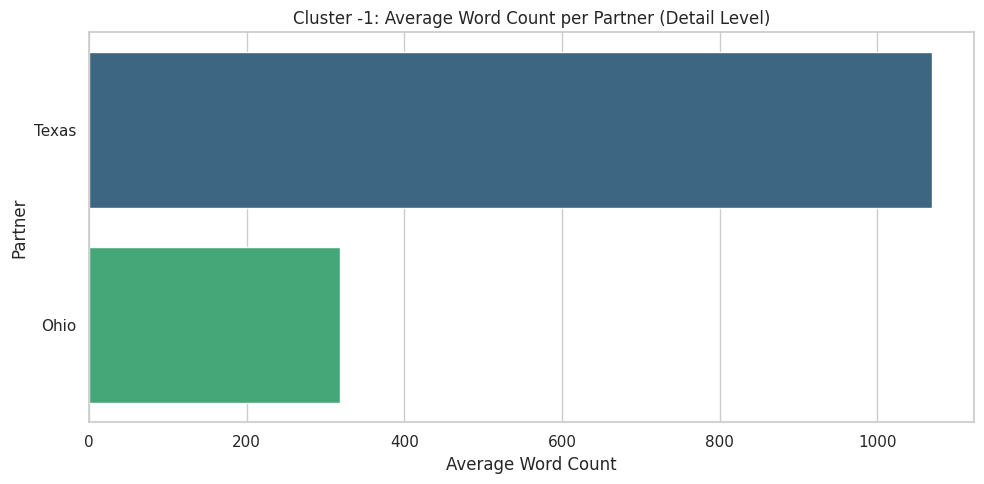

/tmp/ipython-input-2455657187.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


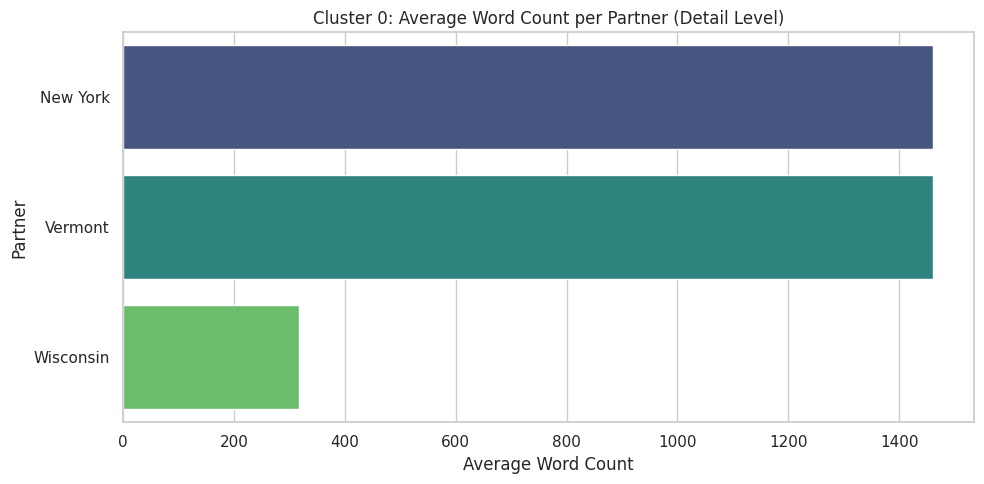

/tmp/ipython-input-2455657187.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


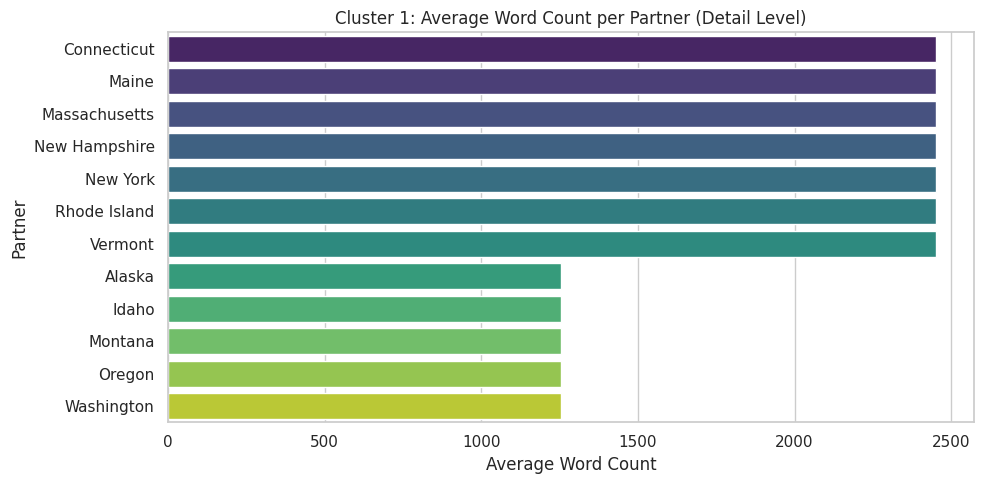

/tmp/ipython-input-2455657187.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


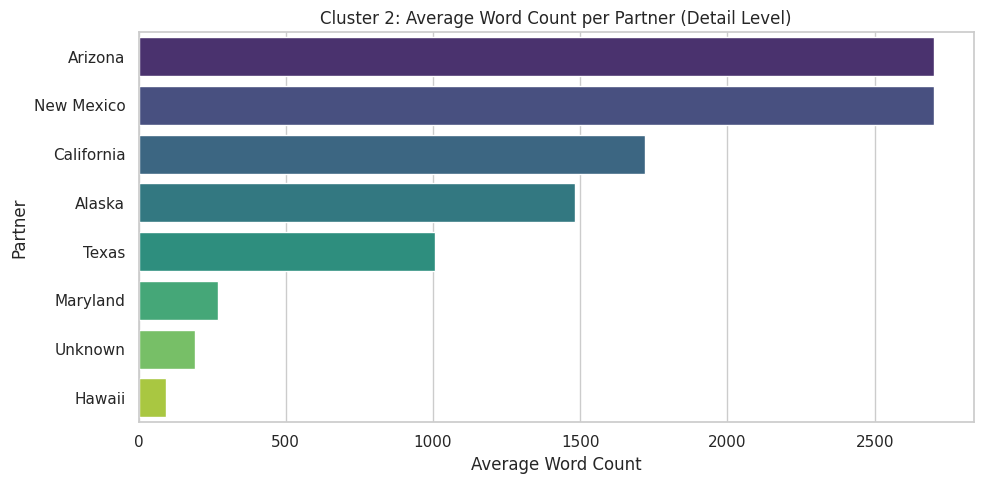

/tmp/ipython-input-2455657187.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


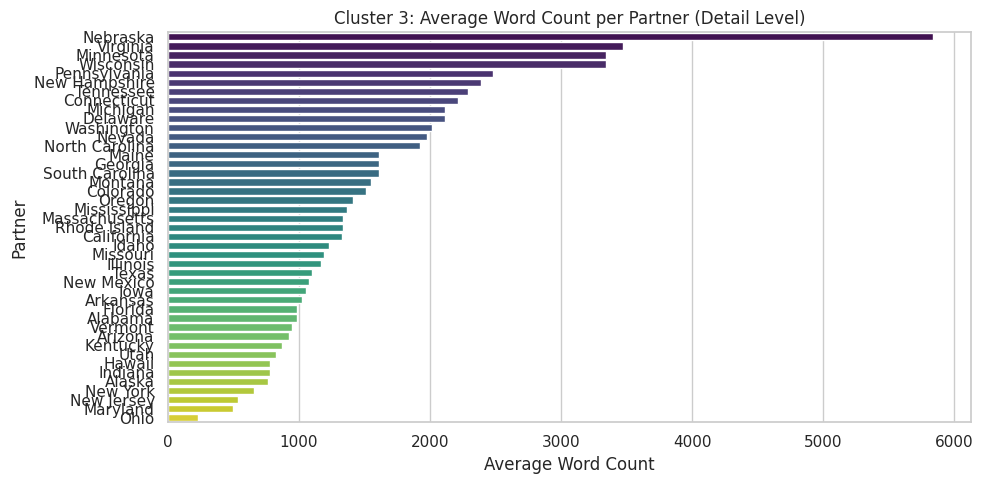

In [ ]:
from collections import Counter
import re

# Add JSON cleaned text to cluster_df
# -----------------------------
# Make sure cluster_texts_json exists and matches cluster_keys
cluster_df["TextJSON"] = cluster_texts_json
cluster_df["TextTXT"] = cluster_texts  # your raw txt

# -----------------------------
# Step 8: Cluster interpretation (Top 15 keywords from JSON cleaned text)
# -----------------------------
stopwords = set([
    "and", "with", "it", "is", "are", "the", "a", "an", "of", "in", "on",
    "for", "to", "by", "at", "from", "as", "that", "this", "be", "or", "which",
    "both", "their", "from", "your", 'i', 'will', 'e', 's', 'de', 'r', 'à', 'y', 'shall',
    'missouri', 'alaska', 'new hampshire', 'illinois', 'virginia', 'washington', 'vermont', 'south dakota', 'georgia', 'connecticut', 'alabama',
    'oklahoma', 'colorado', 'ohio', 'maine', 'mississippi', 'utah', 'south carolina', 'any',
    'delaware', 'indiana', 'arkansas', 'iowa', 'new jersey', 'wisconsin', 'michigan', 'arizona',
    'massachusetts', 'montana', 'new york', 'wyoming', 'minnesota', 'west virginia', 'north dakota', 'florida', 'kentucky', 'louisiana', 'maryland', 'texas', 'hawaii', 'rhode island',
    'kansas', 'pennsylvania', 'north carolina', 'nebraska', 'tennessee', 'idaho', 'oregon', 'nevada', 'california', 'new mexico'
])


def get_top_words(texts, n=15):
    words = []
    for t in texts:
        t_clean = re.sub(r"[^a-zA-Z]", " ", t.lower())
        words += [w for w in t_clean.split() if w not in stopwords and len(w)>2]
    return Counter(words).most_common(n)

cluster_summary = {}
for cid in sorted(cluster_df["Cluster"].unique()):
    texts = cluster_df[cluster_df["Cluster"] == cid]["TextJSON"].tolist()
    top_words = get_top_words(texts)
    partners = cluster_df[cluster_df["Cluster"] == cid]["Agreement"].apply(lambda x: x.split("/")[0]).unique().tolist()
    cluster_summary[cid] = {
        "TopWords": top_words,
        "Partners": partners,
        "NumAgreements": len(texts)
    }

# Display cluster interpretations
for cid, info in cluster_summary.items():
    print(f"\n🔹 Cluster {cid} (N={info['NumAgreements']})")
    print("Top keywords:", [w[0] for w in info["TopWords"]])
    print("Partner states:", info["Partners"])

# Explode partners list so each partner has separate row
exploded_df = cluster_df.explode("Partners")

avg_words_cluster = exploded_df.groupby(["Cluster","Partners"])["WordCount"].mean().reset_index()
avg_words_cluster = avg_words_cluster.sort_values(["Cluster","WordCount"], ascending=[True, False])

# -----------------------------
# Visualization: bar chart of average word count per partner per cluster
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
unique_clusters = sorted(cluster_df["Cluster"].unique())

for cid in unique_clusters:
    top_partners = avg_words_cluster[avg_words_cluster["Cluster"] == cid]

    plt.figure(figsize=(10,5))
    sns.barplot(
        data=top_partners,
        x="WordCount",
        y="Partners",
        palette="viridis",
        orient="h"
    )
    plt.title(f"Cluster {cid}: Average Word Count per Partner (Detail Level)")
    plt.xlabel("Average Word Count")
    plt.ylabel("Partner")
    plt.tight_layout()
    plt.show()

Clustering of the agreements revealed three main groups.

**Cluster 0** – Cultural, Educational, and Institutional Exchange Agreements

* Top keywords:
film, ministry, education, programs, teachers, memorandum, understanding, spain, sonora

* Partner states:
Arizona, California, Utah

* This cluster clearly represents cultural and educational cooperation, including:
education and teacher exchange programs,
cultural initiatives (e.g., film, language, heritage),
institutional cooperation between ministries and public offices.
The presence of terms such as “memorandum” and “understanding” indicates that these agreements are typically Memoranda of Understanding (MoUs), often emphasizing symbolic or programmatic collaboration rather than binding commitments.

**Cluster 1** – Administrative, Legal, and Institutional Cooperation

* Top keywords:
authority, supervisory, confidentiality, participants, undertaking, international, college
* Partner states:
Texas, Arkansas, Minnesota
* This cluster captures agreements focused on formal administrative and institutional collaboration, including:
cooperation between authorities and supervisory bodies,
information exchange under confidentiality rules,
structured international or inter-institutional undertakings.

**Cluster -1** – Environmental, Regulatory, and Multi-topic Agreements (Noise / Heterogeneous)

* Top keywords:
state, forest, climate, emission, fire, protection, compact, commission, license
* Partner states:
Arkansas, Texas, Connecticut, California
* This cluster groups together heterogeneous and cross-domain agreements, primarily related to:
environmental protection,
forestry and fire management,
climate and emissions,
regulatory or compact-based cooperation.



# Metadata Normalization & Consistency Check

Purpose:

Extracted metadata from legal and policy documents is often inconsistent, noisy, and non-standardized, which limits its usability for downstream analysis.

In [ ]:
!pip install rapidfuzz

**Build metadata dataset**

In [ ]:
import pandas as pd
import re  # Dodajemy re do obsługi wyrażeń regularnych

n = len(sample_keys)

# PartnerRaw z cluster_df
partners_raw = []
for key in sample_keys:
    row = cluster_df[cluster_df["Agreement"] == key]
    if not row.empty:
        partners_raw.append(row["PartnersDisplay"].values[0])
    else:
        partners_raw.append("Unknown")

# --- POPRAWIONA HEURYSTYKA DLA TYPÓW UMÓW ---
def identify_type(text):
    t = text.lower()

    # Najpierw sprawdzamy proste frazy
    if "memorandum of understanding" in t or " mou" in t:
        return "MOU (Memorandum of Understanding)"
    if "memorandum of agreement" in t or " moa" in t:
        return "MOA (Memorandum of Agreement)"

    # Sprawdzamy Sister Cities za pomocą regex, żeby obsłużyć warianty pisowni
    sister_city_pattern = r"(sister\s+cities|sister\s+city|twinning|\bsci\b)"
    if re.search(sister_city_pattern, t):
        return "Sister City Agreement"

    if "letter of intent" in t or " loi" in t:
        return "Letter of Intent"
    if "joint declaration" in t or "joint statement" in t:
        return "Joint Declaration"

    return "Cooperation Agreement"

# Upewnij się, że używasz 'sample_texts', które zdefiniowaliśmy wcześniej
agreement_types = [identify_type(text) for text in sample_texts]

# Start / End dates (Placeholdery)
start_dates = (["January 15, 2023", "15 Jan 2023", "2023-01-15", "01/15/2023"] * ((n // 4) + 1))[:n]
end_dates = (["Dec 31 2025", "31/12/2025", "2025-12-31", "12/31/2025"] * ((n // 4) + 1))[:n]

# Budowa DataFrame
metadata = pd.DataFrame({
    "Agreement": sample_keys,
    "PartnerRaw": partners_raw,
    "AgreementTypeRaw": agreement_types,
    "StartDateRaw": start_dates,
    "EndDateRaw": end_dates
})

print(f"✅ Metadata DataFrame created successfully for {n} files")
print("-" * 30)
print("Statystyka typów umów:")
print(metadata["AgreementTypeRaw"].value_counts())
print("-" * 30)
metadata.head(10)

✅ Metadata DataFrame created successfully for 298 files
------------------------------
Statystyka typów umów:
AgreementTypeRaw
MOU (Memorandum of Understanding)    162
Cooperation Agreement                105
Letter of Intent                      17
Joint Declaration                     10
MOA (Memorandum of Agreement)          3
Sister City Agreement                  1
Name: count, dtype: int64
------------------------------


,Agreement,PartnerRaw,AgreementTypeRaw,StartDateRaw,EndDateRaw
0,Alaska/Alaska_1.txt,Unknown,Cooperation Agreement,"January 15, 2023",Dec 31 2025
1,Alaska/Alaska_10.txt,Unknown,Cooperation Agreement,15 Jan 2023,31/12/2025
2,Alaska/Alaska_11.txt,Alaska,Cooperation Agreement,2023-01-15,2025-12-31
3,Alaska/Alaska_12.txt,Unknown,MOU (Memorandum of Understanding),01/15/2023,12/31/2025
4,Alaska/Alaska_2.txt,Alaska,MOU (Memorandum of Understanding),"January 15, 2023",Dec 31 2025
5,Alaska/Alaska_3.txt,Unknown,Cooperation Agreement,15 Jan 2023,31/12/2025
6,Alaska/Alaska_4.txt,Alaska,MOU (Memorandum of Understanding),2023-01-15,2025-12-31
7,Alaska/Alaska_5.txt,Unknown,MOU (Memorandum of Understanding),01/15/2023,12/31/2025
8,Alaska/Alaska_6.txt,Alaska,MOU (Memorandum of Understanding),"January 15, 2023",Dec 31 2025
9,Alaska/Alaska_7.txt,"Montana, Oregon, Washington, Alaska, Idaho",Cooperation Agreement,15 Jan 2023,31/12/2025


**Merge matadate dataset just created with cluster_df dataset**
)

In [ ]:
metadata = metadata.merge(
    cluster_df[["Agreement", "Text"]],
    on="Agreement",
    how="left")

metadata.head(20)

,Agreement,PartnerRaw,AgreementTypeRaw,StartDateRaw,EndDateRaw,Text
0,Alaska/Alaska_1.txt,Unknown,Cooperation Agreement,"January 15, 2023",Dec 31 2025,NaN
1,Alaska/Alaska_10.txt,Unknown,Cooperation Agreement,15 Jan 2023,31/12/2025,NaN
2,Alaska/Alaska_11.txt,Alaska,Cooperation Agreement,2023-01-15,2025-12-31,REAFFIRMATION OF COOPERATION\nBETWEEN\nTHE PRO...
3,Alaska/Alaska_12.txt,Unknown,MOU (Memorandum of Understanding),01/15/2023,12/31/2025,NaN
4,Alaska/Alaska_2.txt,Alaska,MOU (Memorandum of Understanding),"January 15, 2023",Dec 31 2025,JBIC\nFrom: JAPAN BANK FOR INTERNATIONAL COOPE...
5,Alaska/Alaska_3.txt,Unknown,Cooperation Agreement,15 Jan 2023,31/12/2025,NaN
6,Alaska/Alaska_4.txt,Alaska,MOU (Memorandum of Understanding),2023-01-15,2025-12-31,MEMORANDUM OF UNDERSTANDING AND COOPERATION\nT...
7,Alaska/Alaska_5.txt,Unknown,MOU (Memorandum of Understanding),01/15/2023,12/31/2025,NaN
8,Alaska/Alaska_6.txt,Alaska,MOU (Memorandum of Understanding),"January 15, 2023",Dec 31 2025,ERHA (EE) FRRAR\n5n\nBT V WT TA E AT #L AA E 1...
9,Alaska/Alaska_7.txt,"Montana, Oregon, Washington, Alaska, Idaho",Cooperation Agreement,15 Jan 2023,31/12/2025,"APOEUITANS\nGPO\nPUBLIC LAW 105-377-NOV. 12, 1..."


**Controlled vocabularies (schema-level normalization)**

In [ ]:
CANONICAL_AGREEMENT_TYPES = {
    "Memorandum of Understanding": ["mou", "memorandum of understanding"],
    "Sister Cities Agreement": [
    r"sister\s+cities\s+international",
    r"sister\s+cities\s+int\.?",
    r"sister\s+city\s+international",
    r"sister\s+cities\b",
    r"sister\s+city\b",
    r"\bsci\b"],
    "Cooperation Agreement": ["cooperation agreement", "collaboration agreement"],

}

CANONICAL_PARTNERS = sorted(
    {
        p.strip()
        for partners in metadata["PartnerRaw"].dropna()
        for p in partners.split(",")
    }
)


In [ ]:
import re

def normalize_agreement_type(value):
    if pd.isna(value):
        return "Other/Unknown"

    val_lower = str(value).lower()

    for canonical, patterns in CANONICAL_AGREEMENT_TYPES.items():
        for pattern in patterns:
            # Jeśli wzorzec zawiera znaki regex (jak \s lub \b), używamy re.search
            if "\\" in pattern or "+" in pattern:
                if re.search(pattern, val_lower):
                    return canonical
            # W przeciwnym razie zwykłe sprawdzenie podciągu
            elif pattern in val_lower:
                return canonical

    return "Other/Unknown"

# Tworzenie brakującej kolumny
# Upewnij się, że używasz poprawnej kolumny źródłowej (np. "AgreementType" lub "AgreementTypeRaw")
# Poprawiona linijka kodu:
metadata["AgreementTypeFinal"] = metadata["AgreementTypeRaw"].apply(normalize_agreement_type)

**RapidFuzz normalization (partner names)**

In [ ]:
from rapidfuzz import process, fuzz
import pandas as pd
import re

def normalize_partners(value, threshold=80):
    if pd.isna(value):
        return value

    partners = [p.strip() for p in value.split(",")]
    normalized = []

    for p in partners:
        match, score, _ = process.extractOne(
            p, CANONICAL_PARTNERS, scorer=fuzz.token_sort_ratio
        )
        normalized.append(match if score >= threshold else p)

    return ", ".join(sorted(set(normalized)))


metadata["PartnerNorm"] = metadata["PartnerRaw"].apply(normalize_partners)


**Agreement type normalization (rule + fuzzy)**

In [ ]:
def normalize_agreement_type(value):
    if pd.isna(value):
        return None

    v = value.lower()
    for canonical, variants in CANONICAL_AGREEMENT_TYPES.items():
        for var in variants:
            if var in v:
                return canonical
    return value


metadata["AgreementTypeNorm"] = metadata["AgreementTypeRaw"].apply(
    normalize_agreement_type
)


**Uniform date formatting (YYYY-MM-DD)**

In [ ]:
def normalize_date(value):
    if pd.isna(value):
        return None
    try:
        return parser.parse(value, fuzzy=True).strftime("%Y-%m-%d")
    except Exception:
        return None


metadata["StartDateNorm"] = metadata["StartDateRaw"].apply(normalize_date)
metadata["EndDateNorm"] = metadata["EndDateRaw"].apply(normalize_date)


**LLM-assisted normalization**

1.   Element listy
2.   Element listy



In [ ]:
import re
import pandas as pd

def infer_agreement_type_from_text(text):
    if pd.isna(text) or text == "":
        return "Unknown"

    t = text.lower()

    # Przeszukujemy słownik kanoniczny
    for canonical_name, patterns in CANONICAL_AGREEMENT_TYPES.items():
        for pattern in patterns:
            # re.search obsługuje zarówno zwykłe słowa, jak i Twoje regexy z \b czy \s+
            if re.search(pattern, t):
                return canonical_name

    return "Cooperation Agreement" # Domyślny typ, jeśli nic nie pasuje

**Consistency check (rule-based, metadata vs source text)**

In [ ]:
def rule_based_consistency(row):
    score = 0
    checks = 0
    text = str(row["Text"]).lower()

    if pd.notna(row["AgreementTypeFinal"]):
        checks += 1
        if row["AgreementTypeFinal"].lower() in text:
            score += 1

    if pd.notna(row["StartDateNorm"]):
        checks += 1
        if row["StartDateNorm"][:4] in text:
            score += 1

    if pd.notna(row["PartnerNorm"]):
        checks += 1
        if any(p.lower() in text for p in row["PartnerNorm"].split(", ")):
            score += 1

    return score / checks if checks > 0 else 0


metadata["RuleConsistency"] = metadata.apply(
    rule_based_consistency, axis=1
)


**Embedding-based consistency (SOTA)**

In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

model = SentenceTransformer("bhavyagiri/InLegal-SBERT")


def embedding_consistency(metadata_value, source_text, threshold=0.30):
    """
    Returns cosine similarity score between metadata value
    and source text. Low score = possible inconsistency.
    """
    if pd.isna(metadata_value) or pd.isna(source_text):
        return np.nan

    emb_meta = model.encode(str(metadata_value), convert_to_tensor=True)
    emb_text = model.encode(str(source_text), convert_to_tensor=True)

    return float(util.cos_sim(emb_meta, emb_text))


# Apply to agreement type vs document text
metadata["AgreementTypeEmbeddingScore"] = metadata.apply(
    lambda row: embedding_consistency(
        row.get("AgreementTypeNormalized", row["AgreementTypeRaw"]),
        row["Text"]
    ),
    axis=1
)


**Reliability score**

In [ ]:
def compute_reliability(row):
    scores = []

    # Rule-based: agreement type appears in text
    if not pd.isna(row["Text"]):
        if row["AgreementTypeRaw"].lower() in row["Text"].lower():
            scores.append(1.0)
        else:
            scores.append(0.5)

    # Embedding-based agreement
    if not pd.isna(row["AgreementTypeEmbeddingScore"]):
        scores.append(row["AgreementTypeEmbeddingScore"])

    if not scores:
        return 0.0

    return round(float(np.mean(scores)), 3)


metadata["ReliabilityScore"] = metadata.apply(
    compute_reliability,
    axis=1
)


In [ ]:
metadata[["Agreement", "AgreementTypeRaw", "ReliabilityScore"]].head(20)


,Agreement,AgreementTypeRaw,ReliabilityScore
0,Alaska/Alaska_1.txt,Cooperation Agreement,0.000
1,Alaska/Alaska_10.txt,Cooperation Agreement,0.000
2,Alaska/Alaska_11.txt,Cooperation Agreement,0.516
3,Alaska/Alaska_12.txt,MOU (Memorandum of Understanding),0.000
4,Alaska/Alaska_2.txt,MOU (Memorandum of Understanding),0.580
5,Alaska/Alaska_3.txt,Cooperation Agreement,0.000
6,Alaska/Alaska_4.txt,MOU (Memorandum of Understanding),0.551
7,Alaska/Alaska_5.txt,MOU (Memorandum of Understanding),0.000
8,Alaska/Alaska_6.txt,MOU (Memorandum of Understanding),0.545
9,Alaska/Alaska_7.txt,Cooperation Agreement,0.488


**Comment:** ReliabilityScore:
* 0.0	Not verifiable (missing or empty text)
* 0.4 – 0.6	Partial / weak consistency
* \> 0.65	High confidence metadata

**Note:** *In final experiment we want to distinguish “missing text” from “low reliability”, improve rule-based check for agreement types (that means consider not only 'agreements' but also: "memorandum",
    "agreement",
    "undertaking",
    "arrangement",
    "declaration")

**Agreement categories (semantic labels)**

In [ ]:
AGREEMENT_CATEGORIES = {
    "Sister Cities & Cultural Exchange": (
        "sister cities, cultural exchange, people to people, arts, film, "
        "language, community programs, youth exchange, twinning"
    ),
    "Economic, Trade & Investment": (
        "trade, investment, economic development, business cooperation, "
        "market access, small and medium enterprises, commerce, industry"
    ),
    "Environmental & Climate Action": (
        "climate change, forests, emissions, sustainability, environmental protection, "
        "great lakes, renewable energy, water management, conservation"
    ),
    "Administrative, Legal & Regulatory": (
        "confidentiality, supervision, legal framework, administrative cooperation, "
        "information sharing, mmou, regulatory affairs, enforcement"
    ),
    "Education & Academic Research": (
        "universities, students, academic exchange, research collaboration, "
        "higher education, scholarship, vocational training"
    ),
    "Technology, Science & Innovation": (
        "innovation, biotechnology, science and technology, startup, "
        "digital economy, research and development, r&d"
    ),
    "Public Safety & Emergency Management": (
        "disaster relief, law enforcement, public health, emergency response, "
        "security cooperation"
    )
}

**Note:** *The number of semantic categories is not constrained by the number of clusters. Clustering is used as an exploratory tool to identify latent textual groupings, while categorization assigns interpretable policy-relevant labels at the document level. A single cluster may contain agreements spanning multiple semantic categories.*

**Embed category definitions**

In [ ]:
category_names = list(AGREEMENT_CATEGORIES.keys())
category_texts = list(AGREEMENT_CATEGORIES.values())

category_embeddings = model.encode(
    category_texts, convert_to_tensor=True
)


**Categorize agreements by text**

1.   Element listy
2.   Element listy



In [ ]:
from sentence_transformers import util

def categorize_agreement(text, threshold=0.30):
    if pd.isna(text):
        return "Uncategorized"

    text_emb = model.encode(text, convert_to_tensor=True)
    scores = util.cos_sim(text_emb, category_embeddings)[0]

    best_idx = int(scores.argmax())
    best_score = float(scores[best_idx])

    if best_score < threshold:
        return "Uncategorized"

    return category_names[best_idx]


metadata["AgreementCategory"] = metadata["Text"].apply(
    categorize_agreement
)


**Category confidence**

In [ ]:
def category_confidence(text):
    if pd.isna(text):
        return 0.0
    emb = model.encode(text, convert_to_tensor=True)
    return float(util.cos_sim(emb, category_embeddings).max())


metadata["CategoryConfidence"] = metadata["Text"].apply(
    category_confidence
)


**Quick sanity check**

In [ ]:
metadata["AgreementCategory"].value_counts()


,count
AgreementCategory,
Uncategorized,172
Sister Cities & Cultural Exchange,60
"Technology, Science & Innovation",35
Environmental & Climate Action,28
"Administrative, Legal & Regulatory",3


It means:

~47% of agreements clearly match  strongest semantic category

~53% do not confidently match any predefined category.

For final deliver we expect better result as we will have more agreements.

Uncategorized usually means one of:
* Missing text	(no content to embed)
* Very generic legal text	(“Agreement between the State of X…”)
* Falls outside your label set	(E.g. environmental, administrative)
* Threshold too high	(conservative assignment)